In [1]:
import torch

In [2]:
experiment_name = "experiment_1"
result_folder = f"results/{experiment_name}"

In [3]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from torch.amp import  GradScaler, autocast
import torch.nn.functional as F

In [4]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
paths = glob.glob("data/images/*.jpg")
len(paths)

40670

In [7]:
def get_img_paths(fpath,max_val,val_ratio):
  paths = np.random.choice(glob.glob(fpath),max_val,replace=False)
  val_paths = paths[:int(max_val*val_ratio)]
  train_paths = paths[int(max_val*val_ratio):]
  return train_paths,val_paths

In [8]:
train_paths,val_paths = get_img_paths("data/images/*.jpg",20000,0.2)
len(train_paths), len(val_paths)

(16000, 4000)

In [9]:
from utils.dataset import ColorizationDataset, ImageTransformer

In [10]:
trf = ImageTransformer()
train_ds = ColorizationDataset(train_paths, "train", 256, preprocessor=trf)
val_ds = ColorizationDataset(val_paths, "val", 256, preprocessor=trf)

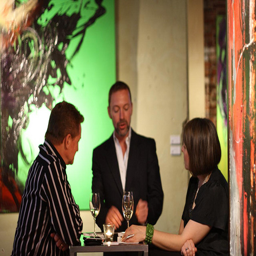

In [11]:
train_ds.return_original = True
img = train_ds[1][2]
train_ds.return_original = False
img

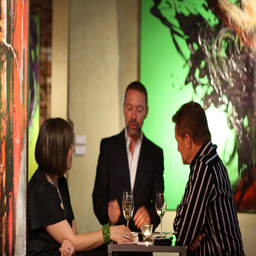

In [12]:
trf.inverse_transform(*train_ds[1])

In [13]:
train_dl = DataLoader(train_ds, batch_size=16,pin_memory=True,shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16,pin_memory=True,shuffle=False)

In [14]:
data = next(iter(train_dl))
Ls, ab_s = data
print(Ls.shape, ab_s.shape)
print(len(train_dl),len(val_dl))

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
1000 250


In [15]:
from utils.models import Unet, PatchDiscriminator

In [16]:
from abc import abstractmethod

In [17]:
import logging
from abc import abstractmethod
from candle.callbacks import Callback
from candle.trainers.base import TrainerModule
import torch
from typing import Optional, List
import copy


class ModelConfig:
    def __init__(self, model, **kwargs):
        self.model = model
        for key, value in kwargs.items():
            setattr(self, key, value)

    def set_requires_grad(self, requires_grad=True):
        for p in self.model.parameters():
            p.requires_grad = requires_grad


class TrainerTemplate(TrainerModule):
    def __init__(self,
                 model: nn.Module,
                 callbacks: Optional[List[Callback]] = None,
                 clear_cuda_cache: bool = True,
                 use_amp: bool = True,
                 device: Optional[torch.device] = None,
                 logger: Optional[logging.Logger] = None):

        super().__init__(model=model, name="SimpleTrainer", device=(device or torch.device('cpu')), logger=logger)

        self.num_batches = None
        self.batch_size = None
        self._current_epoch = 0

        self.clear_cuda_cache = clear_cuda_cache
        self.use_amp = use_amp and self.device.type == 'cuda'
        self.tracker = self.init_tracker()

        self.STOPPER = False
        self.external_events = set()
        self._best_state_dict = None
        self._final_metrics = {}

        self.std_pos = {'on_train_batch_begin', 'on_train_batch_end', 'on_epoch_begin', 'on_epoch_end',
                        'on_test_batch_begin', 'on_test_batch_end', 'on_predict_batch_begin', 'on_predict_batch_end',
                        'on_train_begin', 'on_train_end', 'on_test_begin', 'on_test_end', 'on_predict_begin',
                        'on_predict_end', 'before_training_starts', 'after_training_ends', 'before_backward_pass'}
        self.callbacks = self.set_callbacks(callbacks or [])

    @abstractmethod
    def init_tracker(self):
        pass

    @abstractmethod
    def training_step(self, inputs, labels):
        pass

    @abstractmethod
    @torch.no_grad()
    def eval_step(self, inputs, labels):
        pass

    @abstractmethod
    @torch.no_grad()
    def prediction_step(self, data):
        return self.model(data)

    @abstractmethod
    def save_progress(self, *args, **kwargs):
        pass

    @abstractmethod
    def load_progress(self, *args, **kwargs):
        pass

    @abstractmethod
    def reset_progress(self):
        self._current_epoch = 0
        self.STOPPER = False
        self._best_state_dict = None
        self._final_metrics = {}
        self.tracker = self.init_tracker()

    def _run_callbacks(self, pos: str) -> List[Optional[str]]:
        return self.callbacks.run_all(pos)

    def train(self, train_loader: torch.utils.data.DataLoader) -> None:
        self.model.train()
        self._run_callbacks(pos="on_train_begin")
        for inputs, labels in self.progress_bar(position='training',
                                                iterable=train_loader,
                                                desc=self.epoch_headline):
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            self._run_callbacks(pos="on_train_batch_begin")

            self.training_step(inputs, labels)

            self._run_callbacks(pos="on_train_batch_end")
        self._run_callbacks(pos="on_train_end")

    @torch.no_grad()
    def validate(self, val_loader: torch.utils.data.DataLoader) -> None:
        self.model.eval()
        self._run_callbacks(pos="on_test_begin")
        for inputs, labels in self.progress_bar(position='validation', iterable=val_loader, desc="Validation: "):
            self._run_callbacks(pos="on_test_batch_begin")
            inputs, labels = inputs.to(self.device), labels.to(self.device)

            self.eval_step(inputs, labels)

            self._run_callbacks(pos="on_test_batch_end")
        self._run_callbacks(pos="on_test_end")

    @property
    def current_epoch(self):
        return self._current_epoch

    def fit(self, train_loader: torch.utils.data.DataLoader, val_loader: torch.utils.data.DataLoader,
            epochs: int = 1, epoch_start: int = 0):
        """
        Trains the model for the specified number of epochs.

        Args:
            train_loader (torch.utils.data.DataLoader): DataLoader for training datasets.
            val_loader (torch.utils.data.DataLoader): DataLoader for validation datasets.
            epoch_start (int): from what epoch number we should start
            epochs (int): No. of epochs to run for

        Returns:
            None
        """
        self.reset_progress()
        self.epochs = epochs
        self.num_batches = len(train_loader)
        self.batch_size = train_loader.batch_size
        on_gpu = True if self.device.type == 'cuda' else False

        self._run_callbacks(pos="before_training_starts")
        for self._current_epoch in range(epoch_start, epoch_start + self.epochs):
            self._run_callbacks(pos="on_epoch_begin")

            if on_gpu and self.clear_cuda_cache:
                torch.cuda.empty_cache()

            self.train(train_loader)
            self.validate(val_loader)

            self._run_callbacks(pos="on_epoch_end")
            self.tracker.snap_and_reset_all()

            if self.STOPPER:
                break

        self._run_callbacks(pos="after_training_ends")
        return self.tracker.get_history()

    @property
    def final_metrics_(self):
        return self._final_metrics or self.tracker.get_final_values(self.current_epoch)

    @property
    def best_state_dict_(self):
        return self._best_state_dict or copy.deepcopy(self.model.state_dict())

    def predict(self, data_loader: torch.utils.data.DataLoader) -> torch.Tensor:
        """Predicts outputs for the given DataLoader.

        Args:
            data_loader (torch.utils.data.DataLoader): DataLoader providing input datasets for prediction.

        Returns:
            torch.Tensor: Concatenated model predictions for all input batches.
        """
        self.model.eval()
        self._run_callbacks(pos="on_predict_begin")

        all_predictions = []
        for batch_idx, data in self.progress_bar(position="prediction",
                                                 iterable=enumerate(data_loader),
                                                 desc="Processing"):
            self._run_callbacks(pos="on_predict_batch_begin")
            data = data.to(self.device)
            predictions = self.prediction_step(data)
            all_predictions.append(predictions)
            self._run_callbacks(pos="on_predict_batch_end")

        all_predictions = torch.cat(all_predictions, dim=0)
        self._run_callbacks(pos="on_predict_end")
        return all_predictions

In [18]:
class ImageColorizationModel(nn.Module):
    def __init__(self, generator,
                 discriminator,):
        super().__init__()
        self.gen = self.init_weights(generator)
        self.disc = self.init_weights(discriminator)

    @staticmethod
    def init_weights(net, init='norm', gain=0.02):
        def init_func(m):
            classname = m.__class__.__name__
            if hasattr(m, 'weight') and 'Conv' in classname:
                if init == 'norm':
                    nn.init.normal_(m.weight.data, mean=0.0, std=gain)
                elif init == 'xavier':
                    nn.init.xavier_normal_(m.weight.data, gain=gain)
                elif init == 'kaiming':
                    nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias.data, 0.0)
            elif 'BatchNorm2d' in classname:
                nn.init.normal_(m.weight.data, 1., gain)
                nn.init.constant_(m.bias.data, 0.)
        net.apply(init_func)
        print(f"model initialized with {init} initialization")
        return net

In [19]:
model = ImageColorizationModel(Unet(), PatchDiscriminator(3))

model initialized with norm initialization
model initialized with norm initialization


In [20]:
generator = ModelConfig(
    model = model.gen,
    name = "generator",
    optimizer = optim.Adam(model.gen.parameters(), lr=2e-4, betas=(0.5, 0.999)),
    scaler = GradScaler(enabled=torch.cuda.is_available())
)

In [21]:
discriminator = ModelConfig(
    model = model.disc,
    name = "discriminator",
    optimizer = optim.Adam(model.disc.parameters(), lr=2e-4, betas=(0.5, 0.999)),
    scaler = GradScaler(device = "cuda" if torch.cuda.is_available() else "cpu",enabled=torch.cuda.is_available())
)

In [22]:
from candle.utils.tracking import Tracker

In [23]:
class ImageSaver(Callback):
    def __init__(self, L, real_ab, trnsformer, save_path, show=False):
        super().__init__()
        self.L = L
        self.real_ab = real_ab
        self.save_path = lambda idx: os.path.join(save_path, f"generated_{idx}.jpg")
        os.makedirs(save_path, exist_ok=True)
        self.trf = trnsformer
        self.show = show

    @torch.no_grad()
    def save_generated(self, current_epoch, L, real_ab, nmax = 4 ):
        L, real_ab = self.to_device(L), self.to_device(real_ab)
        save_path = self.save_path(current_epoch)
        fake_ab = self.model.gen(L)
        nmax = min(nmax, L.size(0))
        real_images = self.trf.inverse_transform_batch(L, real_ab, rtype="np")
        fake_images = self.trf.inverse_transform_batch(L, fake_ab, rtype="np")

        fig, axes = plt.subplots(3, nmax, figsize = (15, 8))
        fig.suptitle(f"Generated Images at Epoch {current_epoch}", fontsize = 16)

        for i in range(nmax):
            axes[0, i].imshow(L[i][0].cpu(), cmap='gray')
            axes[0, i].axis("off")
            if i == 0:
              axes[0, i].set_title("Input (L)")
            axes[1, i].imshow(fake_images[i])
            axes[1, i].axis("off")
            if i == 0:
              axes[1, i].set_title("Generated (Fake)")
            axes[2, i].imshow(real_images[i])
            axes[2, i].axis("off")
            if i == 0:
              axes[2, i].set_title("Real (AB)")
        fig.savefig(save_path, bbox_inches='tight')
        if self.show:
              plt.show()
        plt.close(fig)

    def on_epoch_end(self):
        self.save_generated(self.trainer.current_epoch, self.L, self.real_ab)

In [24]:
class CheckpointSaver(Callback):
    def __init__(self, save_path, save_interval):
        super().__init__()
        self.save_path = lambda epoch: os.path.join(save_path, f"epoch_{epoch}.pt")
        os.makedirs(save_path, exist_ok=True)
        self.save_interval = save_interval

    def on_epoch_end(self):
        if self.trainer.current_epoch % self.save_interval == 0:
            self.trainer.save_progress(self.save_path(self.trainer.current_epoch))


In [25]:
class ColorizationTrainer(TrainerTemplate):
    def __init__(self,
                 model,
                 generator_config,
                 discriminator_config,
                 callbacks,
                 gan_loss,
                 l1_lambda):
        super().__init__(model = model,
                         callbacks=callbacks,
                         clear_cuda_cache=True,
                         use_amp=True,
                         device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                         logger=None)

        self.gen = generator_config
        self.disc = discriminator_config
        self.gan_loss = gan_loss
        self.l1_lambda = l1_lambda

    def init_tracker(self):
        return Tracker(["gen_loss", "disc_loss", "l1_loss", "val_loss"])

    def train_discriminator(self, L, real_ab):
        # self.disc.model.train()
        self.disc.set_requires_grad(True)
        L, real_ab = self.to_device(L), self.to_device(real_ab)

        self.disc.optimizer.zero_grad()
        with autocast(device_type=self.device.type, enabled=self.use_amp):
            real_images = torch.cat([L, real_ab], dim=1)
            real_predicted = self.disc.model(real_images)
            real_loss = self.gan_loss(real_predicted, is_real=True)

            with torch.no_grad():
                fake_ab = self.gen.model(L)
                fake_images = torch.cat([L, fake_ab], dim=1)
            fake_predicted = self.disc.model(fake_images.detach())
            fake_loss = self.gan_loss(fake_predicted, is_real=False)

            disc_loss = (real_loss + fake_loss) * 0.5

        self.disc.scaler.scale(disc_loss).backward()
        self.disc.scaler.step(self.disc.optimizer)
        self.disc.scaler.update()

        return disc_loss.item()

    def train_generator(self, L, real_ab):
        # self.gen.model.train()
        self.disc.set_requires_grad(False)

        self.gen.optimizer.zero_grad()
        with autocast(device_type=self.device.type, enabled=self.use_amp):
            fake_ab = self.gen.model(L)
            fake_images = torch.cat([L, fake_ab], dim=1)
            fake_predicted = self.disc.model(fake_images)
            gen_loss = self.gan_loss(fake_predicted, is_real=True)
            l1_loss = F.l1_loss(fake_ab, real_ab)
            total_loss = gen_loss + (self.l1_lambda * l1_loss)

        self.gen.scaler.scale(total_loss).backward()
        self.gen.scaler.step(self.gen.optimizer)
        self.gen.scaler.update()

        return gen_loss.item(), l1_loss.item()

    @torch.no_grad()
    def validate_generator(self, L, real_ab):
        # self.gen.model.eval()
        with autocast(device_type=self.device.type, enabled=self.use_amp):
            fake_ab = self.gen.model(L)
            val_loss = F.mse_loss(fake_ab.detach(), real_ab)
        return val_loss.item()

    def training_step(self, L, real_ab):
        disc_loss = self.train_discriminator(L, real_ab)
        gen_loss, l1_loss = self.train_generator(L, real_ab)
        self.tracker.update({"gen_loss": gen_loss, "disc_loss": disc_loss, "l1_loss": l1_loss})

    def eval_step(self, L, real_ab):
        val_loss = self.validate_generator(L, real_ab)
        self.tracker.update({"val_loss": val_loss})

    def prediction_step(self, L):
        fake_ab = self.gen.model(L)
        return torch.cat([L, fake_ab], dim=1)

    def save_progress(self, save_path):
            values = {
                "epoch": self.current_epoch,
                "gen":{
                    "model": self.gen.model.state_dict(),
                    "optimizer": self.gen.optimizer.state_dict(),
                    "scaler": self.gen.scaler.state_dict()
                },
                "disc":{
                    "model": self.disc.model.state_dict(),
                    "optimizer": self.disc.optimizer.state_dict(),
                    "scaler": self.disc.scaler.state_dict()
                },
                "tracker": self.tracker
            }
            torch.save(values, save_path)

    def load_progress(self, save_path):
        values = torch.load(save_path)
        self.gen.model.load_state_dict(values["gen"]["model"])
        self.gen.optimizer.load_state_dict(values["gen"]["optimizer"])
        self.gen.scaler.load_state_dict(values["gen"]["scaler"])

        self.disc.model.load_state_dict(values["disc"]["model"])
        self.disc.optimizer.load_state_dict(values["disc"]["optimizer"])
        self.disc.scaler.load_state_dict(values["disc"]["scaler"])

        self.tracker = values["tracker"]
        self._best_state_dict = self.gen.model.state_dict()
        self._final_metrics = self.tracker.get_final_values(self.current_epoch)
        self._current_epoch = self.tracker.current_epoch

    def reset_progress(self):
        self._current_epoch = 0
        self.STOPPER = False
        self._best_state_dict = None
        self._final_metrics = {}
        self.tracker = self.init_tracker()

In [26]:
from utils.gan_loss import GANLoss

In [27]:
from candle.callbacks import ConsoleLogger

In [28]:
trainer = ColorizationTrainer(
    model = model,
    generator_config = generator,
    discriminator_config = discriminator,
    callbacks = [CheckpointSaver(result_folder + "/checkpoints", 10),
                 ConsoleLogger(progress_bar_positions=["training", "validation"]),
                 ImageSaver(*next(iter(val_dl)), trf, result_folder + "/generated_images", show=False)],
    gan_loss = GANLoss().to(device),
    l1_lambda = 100
)

In [ ]:
trainer.fit(train_dl, val_dl, epochs=20)

---------------------------------------------Progress---------------------------------------------
Validation: 100%|██████████| 250/250 [01:19<00:00,  3.16it/s]
--> Metrics:   gen_loss: 1.3372 ,disc_loss: 0.5348 ,l1_loss: 0.0900 ,val_loss: 0.0170
Time elapsed: 574.3022351264954 s
----------------------------------------------------------------------------------------------------
Validation: 100%|██████████| 250/250 [00:51<00:00,  4.89it/s]
--> Metrics:   gen_loss: 1.1600 ,disc_loss: 0.5780 ,l1_loss: 0.0903 ,val_loss: 0.0196
Time elapsed: 1048.2513716220856 s
----------------------------------------------------------------------------------------------------
Validation: 100%|██████████| 250/250 [00:52<00:00,  4.75it/s]
--> Metrics:   gen_loss: 1.1430 ,disc_loss: 0.5760 ,l1_loss: 0.0896 ,val_loss: 0.0171
Time elapsed: 1493.0412111282349 s
----------------------------------------------------------------------------------------------------
Validation: 100%|██████████| 250/250 [01:13<00:00,

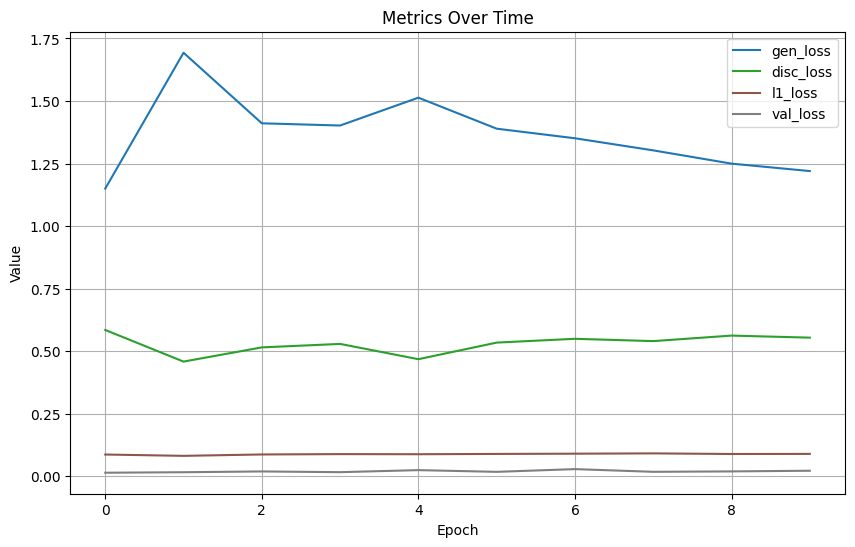

In [32]:
trainer.tracker.plot("gen_loss", "disc_loss", "l1_loss", "val_loss")